In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import eig
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import time as time
%matplotlib inline

# THE SVD and Image Compression

The following notebook chronicles my attempt at coding my own SVD algorithm.  This tale spans vast swaths of numerical linear algebra, and in the end, we manage to slay the beast that is the SVD algorithm.

The blocks of code below implement the SVD algorithm.  The first main block was my attempt to integrate some other algorithms I coded into the SVD.

In [2]:
#A is the matrix, x0 is the first guess, num is the max number of iterations
def Power(A,x0,num,tol):
    #initial stuff, normalize x0 first
    i = 1
    p = np.abs(x0).argmax()
    
    #find the eigenvector and value
    while i <= num:
        #new x with matrix mult Ax
        y = np.dot(A,x0)
        
        #find the biggest element to normalize/eigenvalue
        p = np.abs(y).argmax()
        lam = y[p]
        
        #get error and test to see if tolerance is ok, also update x0
        err = max(np.abs(x0 - y/lam))
              
        x0 = y/lam
              
        if err < tol:
            return(lam,x0)
         
        #add index
        i = i+1
        
    #give eigenvalue and eigenvector    
    return lam,x0

#A is matrix, q is initial guess, num is iterates, x0 is eigenvector approx
def inv_Power(A,x0,num,tol):
    #find the q value, make the q identity matrix
    q = np.dot(x0,np.dot(A,x0))/np.dot(x0,x0)
    dim = np.shape(A)[0]
    q_id = q*np.eye(dim)
    
    #set i
    i = 1
    
    #find the max element and normalize
    p = np.abs(x0).argmax()
    x0 = x0/x0[p]
    
    #run iterates
    while i <= num:
        #solve system
        y = np.linalg.solve(A - q_id,x0)
        
        #get maximal element and lambda approximation
        p = np.abs(y).argmax()
        
        moo = 1/y[p] + q
        
        
        #find error
        err = max(np.abs(x0 - y/y[p]))
        #normalize
        x0 = y/y[p]
        
        #say if the error is good with the tolerance
        if err < tol:
            return(moo,x0)
        
        #increase index by 1
        i = i+1
    
    return moo, x0
        

#A is the input matrix, v is our guess for the eigenvector
def weilandt_combo(A,lam,vec,num,tol):
    
    #get the matrix to subtract from A
    x = 1/(lam*vec)
    vx = np.outer(vec,x)
    
    #make new B matrix
    B = A - lam*vx
    B1 = B[1:,1:]
    
    #solve the new system using the power method to get the new stuff
    lam1,vec1 = Power(B1,vec[1:],num,tol)
    
    vec1 = np.insert(vec1,0,0)
    
    v_new = (lam1 - lam)*vec1 + lam*(np.dot(x,vec1))*vec
    lamm, vec_newnew = inv_Power(A,v_new,num,tol)
    
    
    #use the inverse power method to get the new stuff
    return lamm,vec_newnew, B

#define householder transformation
def Householder(A):
    v = A.copy()
    v[0] = A[0] + np.sign(A[0]) * np.linalg.norm(A)
    H = np.eye(A.shape[0])
    H -= (2./np.matmul(v,v)) * np.matmul(v[:,None],v[None,:])
    
    return H

#define QR factorization, gonna use it for GS-orthogonalization
def QR(A):
    m,n = A.shape
    Q = np.eye(m)
    R = A
    for i in range (n-(n==m)):
        H = np.eye(m)

        H[i:,i:] = Householder(R[i:,i])
        
        Q = np.dot(Q,H)
        R = np.dot(H,R)
        
    return Q,R
    

In [3]:
#this function takes the matrix A and gets the eigendata of A^TA, AA^T
def get_eigen(A):
    n,m = np.shape(A)
    gram = np.matmul(np.transpose(A),A)    #V matrix
    gramT = np.matmul(A,np.transpose(A))   #U matrix
    
    ### ATTEMPT TO INTEGRATE POWER METHOD, INV POWER, WEILANDT DEFLATION...FAILS SOME EASY EXAMPLES DUE TO A SINGULAR MATRIX IN THE INVERSE POWER METHOD ###
    #set tolerances and max iterations
#     num = 1000
#     tol = 10**(-7)
    
#     #do V first
#     V = np.empty((m,m))
#     gramv_eig = np.empty(m)
#     guess = np.ones(m)          #initial guess
    
#     gramv_eig[0],V[:,0] = Power(gram,guess,num,tol)
#     B = gram.copy()
#     for i in range(1,m):
#         gramv_eig[i],V[:,i],gram = weilandt_combo(gram,gramv_eig[i-1],V[:,i-1],num,tol)
    
#     #now for U
#     U = np.empty((n,n))
#     gramu_eig = np.empty(n)
#     guess = np.ones(n)
    
#     gramu_eig[0],U[:,0] = Power(gramT,guess,num,tol)
#     C = gramT.copy()
#     for i in range(1,n):
#         gramu_eig[i],U[:,i],gramT = weilandt_combo(gramT,gramu_eig[i-1],U[:,i-1],num,tol)

    
    #get the eigenvalues and eigenvectors
    gramv_eig, V = np.linalg.eig(gram)    #V matrix
    gramu_eig, U = np.linalg.eig(gramT)  #U matrix
    
    return U,V,gramv_eig,gramu_eig

def eig_reord_shape(U,V,gramv_eig,gramu_eig):
    
    #sort the eigenvalues and eigenvectors so that the order is descending corresponding to their eigenvalues
    ind0 = gramv_eig.argsort()[::-1]
    gramv_eig = gramv_eig[ind0]
    V = V[:,ind0]
    
    ind1 = gramu_eig.argsort()[::-1]
    gramu_eig = gramu_eig[ind1]
    U = U[:,ind1]
    
    #if any of the eigenvalues are close to 0, then set them to 0
    for i in range(len(gramv_eig)):
        if abs(gramv_eig[i]) < 10**(-14):
            gramv_eig[i] = 0
            
    for i in range(len(gramu_eig)):
        if abs(gramu_eig[i]) < 10**(-14):
            gramu_eig[i] = 0
    
    return U,V,gramv_eig,gramu_eig

#this function will orthogonalize the vectors that have 0 as an eigenvalue
def orthog(U,V):
    for i in range(V.shape[0]-1):        
        if (abs(np.dot(V[:,i],V[:,i+1])) > 10**(-14)):   
            G = np.linalg.qr(V[:,i:])[0]          #QR(V[:,i:])[0] gives errors with complex inputs                          
            V[:,i:] = G
    
    for i in range(U.shape[0]-1):
        if (abs(np.dot(U[:,i],U[:,i+1])) > 10**(-14)):
            T = np.linalg.qr(U[:,i:])[0]          #QR(U[:,i:])[0] gives errors with complex inputs                    
            U[:,i:] = T
    
    
    return U,V

#this will check to see if the relationship Av_i = s_iv_i holds if not, it'll switch up the sign
def sanity_check(A,U,V,S,gramv_eig):
    #since only the first k values of U will give nonzero values, range over k
    k = len(gramv_eig)
    
    if np.allclose(np.dot(A,V),np.dot(U,S)) == False:
        for i in range(k):
            left = np.dot(A,V[:,i])
            right = S[i,i]*U[:,i]
            if np.allclose(left,right,atol = 10**(-2)) == False:
                U[:,i] = -U[:,i]
    
    return U,V

def SVD(A):
    n,m = A.shape
    
    #get the eigendata from the A^TA and AA^T matrices
    U,V,gramv_eig,gramu_eig = get_eigen(A)
    
    #reorder the eigenvalues and their corresponding eigenvectors into descending order
    U,V,gramv_eig,gramu_eig= eig_reord_shape(U,V,gramv_eig,gramu_eig)
    
    #orthogonalize any vectors that have 0 as their eigenvalues
    U,V = orthog(U,V)
            
    #get the singular values in descending order and make S matrix
    sing_values = np.diag(np.sqrt(np.abs(gramv_eig)))
    S = np.vstack([sing_values,np.zeros((n-len(gramv_eig),m))])
    
    #this checks the relationship Av_i = s_iv_i and changes the sign of u_i if it doesn't hold
    U,V = sanity_check(A,U,V,S,gramv_eig)
    
    #tranpose the V matrix
    VT = np.transpose(V)
    
    
    #get the singular values of 
    return U,S,VT

In [4]:
#check to make sure it works on a random matrix
A = np.array([[5,2,3,1,1],[1,2,1,4,2],[1,-1,0,1,2],[1,2,3,1,3],[2,1,3,1,3],[1,3,1,4,9],[1,3,1,4,12],[0,0,0,0,1],[12,42,1,2,4]])
U,S,V = SVD(A)
print(np.allclose(A,U@S@V,atol = 10**(-6)), np.allclose(np.eye(A.shape[0]),U@U.T), np.allclose(np.eye(A.shape[1]),V@V.T))

True True True


So the SVD algorithm is finally functional, $U$ and $V$ are also orthonormal so we are good.  Now, we will import the olivetti dataset from sklearn to begin playing with it

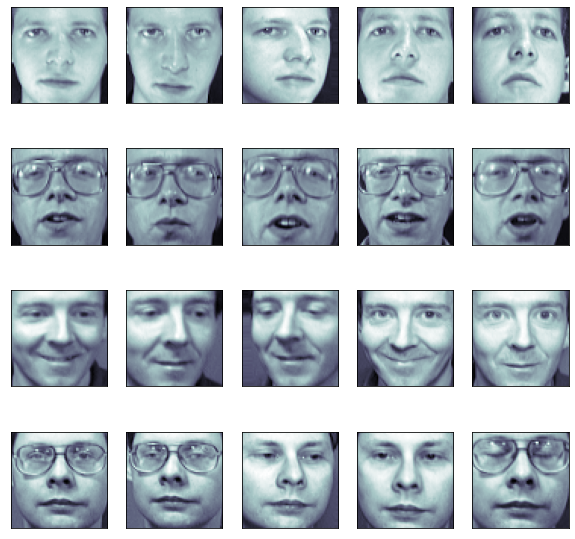

In [5]:
face = datasets.fetch_olivetti_faces()

#let's visualize some of the nice faces
fig = plt.figure(figsize=(10, 10))
Ss = np.empty((64,64*20))
for i in range(20):
    U,Ss[:,64*i:64 + 64*i],V = SVD(face.images[2*i])
    ax = fig.add_subplot(4, 5, i + 1,xticks = [],yticks = [])
    ax.imshow(U@Ss[:,64*i:64 + 64*i]@V, cmap=plt.cm.bone)
    
plt.savefig('/Users/laurencepalmer/Desktop/20_oliv_faces.png')

Now, let's try to compress the images for a few different sizes.  First, let's perform some exploratory analysis on how much information we should retain in order to get a decent approximation to the original images.  We will do this by analyzing at what point the percentage of the sum of the previous r singular values dips below a certain percentage threshold of 90%.  Essentially, we will find $r$ so that 

$$\frac{\sum_{i=1}^r s_i}{\sum_{i=1}^n s_i} < 0.9$$

The following code does this.

In [6]:
#attempt at percentages 
totals = np.zeros(20)
ranks = np.zeros(20)

#set the percentage threshold
thresh = .9

for i in range(20):
    summ = 0
    totals[i] = sum(Ss[np.arange(0,64),np.arange(i*64,(i+1)*64)])
    for j in range(64):
        summ = Ss[j,i*64 + j] + summ
        if summ/totals[i] < thresh: #once it reaches the threshold it will stop updating the ranks so this should be the appropriate rank approx
            ranks[i] = j

ranks

array([ 8.,  9.,  9., 10.,  9., 14., 13., 12., 15., 13.,  9.,  8.,  8.,
       11., 10., 15., 15.,  9.,  7., 13.])

So we have a bunch of different rank approximations that should keep 90% accuracy of the original image, we hope.  Let's visualize these 

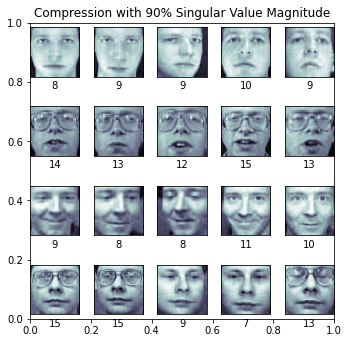

In [7]:
fig = plt.figure(figsize=(5,5),frameon = False)
plt.title('Compression with 90% Singular Value Magnitude')

for i in range(20):
    k = int(ranks[i])
    U,S,V = SVD(face.images[2*i])
    ax = fig.add_subplot(4, 5, i+1,xticks = [],yticks = [])
    plt.xlabel(k)
    plt.tight_layout()
    ax.imshow(U[:,:k]@S[:k,:k]@V[:k,:], cmap=plt.cm.bone)    #compression step
    
plt.savefig('/Users/laurencepalmer/Desktop/20_oliv_faces_90p_rank.png')

As we can see, not much detail is added from rank 9 to rank 14, but there is a clear different between the rank 4 and rank 9 compressions.  Let's take a look at the differences between these two in order to get a sense of the level of detail being added from each image.

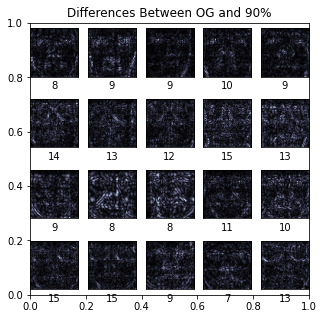

In [8]:
fig = plt.figure(figsize=(5,5),frameon = False)
plt.title('Differences Between OG and 90%')

for i in range(20):
    k = int(ranks[i])
    U,S,V = SVD(face.images[2*i])
    ax = fig.add_subplot(4, 5, i+1,xticks = [],yticks = [])
    plt.xlabel(k)
    ranki = U[:,:k]@S[:k,:k]@V[:k,:]
    OG = U[:,:64]@S[:64,:64]@V[:64,:]
    diff = abs(OG -ranki)
    ax.imshow(diff, cmap=plt.cm.bone)   
    
plt.savefig('/Users/laurencepalmer/Desktop/rankOG_90_differences.png')



As we can see, there are some features that are being lost, but overall, there are not a lot of important features that are being lost.  Let's get more measures on the absolute differences.  We will take the absolute value of the differences between the original image and the approximations, and divide it by the absolute value of the originals.  This is imperfect, but will give us a sense of how much information we are losing.

In [9]:
k = [64,29,9,4]
abs_diff_p = np.zeros(20)
abs_diff =  np.zeros(20)

for i in range(20):
    k = int(ranks[i])
    U,S,V = SVD(face.images[2*i])
    ax = fig.add_subplot(4, 5, i+1,xticks = [],yticks = [])
    rank64 = U[:,:64]@S[:64,:64]@V[:64,:]
    rank_90 = U[:,:k]@S[:k,:k]@V[:k,:]
    abs_diff_p[i] = sum(sum(np.abs(rank64 -rank_90)))/sum(sum(np.abs(rank64)))
    abs_diff[i] = sum(sum(np.abs(rank64 -rank_90)))
abs_diff,abs_diff_p

(array([69.08298839, 69.94938629, 71.96010573, 66.92964003, 71.2147339 ,
        68.66722216, 73.90146147, 68.30709066, 70.86203547, 73.87470562,
        67.14077926, 73.41006735, 65.04728133, 67.1456491 , 68.26323379,
        67.44463651, 68.97862078, 71.31710154, 71.46651785, 66.61122453]),
 array([0.02648355, 0.027419  , 0.02883012, 0.02557729, 0.02674898,
        0.02982167, 0.03228373, 0.02903239, 0.03278756, 0.0325428 ,
        0.03182071, 0.03433566, 0.03104086, 0.02848726, 0.02836297,
        0.03007875, 0.03136983, 0.02924095, 0.02845758, 0.03057091]))

Now, can I compress an image on my computer so it takes less storage?

(1200, 903)


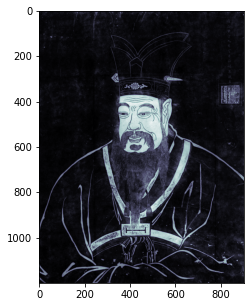

In [10]:
img = mpimg.imread('/Users/laurencepalmer/Desktop/confucius-9254926-1-raw.png')
figure = plt.figure(figsize = (5,5))
plt.imshow(img,cmap = plt.cm.bone)
plt.imsave('/Users/laurencepalmer/Desktop/OG_desktop_pic.png',img,cmap = plt.cm.bone)
print(img.shape)

This picture is actually one of my desktop screensavers. Currently, it takes up 621 KB on my computer.  Let's apply the same process that we applied to the olivetti faces to figure out what rank approximation we want to use. We'll also time our algorithm against np.linalg.svd, and also plot the singular values of this image as well.  

In [12]:
#time the algorithms a few times average the time values in case 
n = 10
my_time = np.zeros(10)
their_time = np.zeros(10)

#store all the times in the same array because we can just overwrite them
start = np.zeros(10)
end = np.zeros(10)

for i in range(10):
    start[i] = time.time()
    U,S,V = SVD(img)
    end[i] = time.time()
    my_time[i] = end[i]-start[i]

    start[i] = time.time()
    _,_,_ = np.linalg.svd(img)
    end[i] = time.time()
    their_time[i] = end[i]-start[i]

print(np.average(my_time),np.average(their_time))

28.752281069755554 0.14632682800292968


Let's take a look at the values a little more

In [13]:
times = pd.DataFrame(np.transpose([my_time,their_time]),columns = {'my_time','their_times'})
times.describe()

,their_times,my_time
count,10.000000,10.000000
mean,28.752281,0.146327
std,1.055571,0.005234
min,27.643972,0.137578
25%,28.231659,0.142843
50%,28.424527,0.145950
75%,28.880119,0.148746
max,31.243944,0.154283


It seems that my perfomance is not bad at all.  I will take doubling the run time of np.linalg.svd as a success given how much they have optimized the library.  Let's run the rank finding procedure again.

325


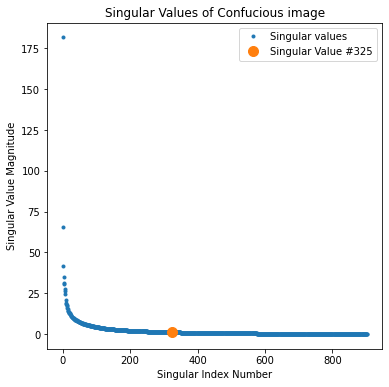

In [27]:
#set threshold and run rank finding procedure again
U,S,V = SVD(img)
ranks = 0
summ = 0
sing = np.zeros(903)

#set the percentage threshold
thresh = .9

#there can only be 903 nonzero singular values by the dimensions of the image
totals = sum(S[np.arange(903),np.arange(903)])
for j in range(903):
    summ = S[j,j] + summ
    sing[j] = S[j,j]
    if summ/totals < thresh: #once it reaches the threshold it will stop updating the ranks so this should be the appropriate rank approx
        ranks = j

print(ranks)
plt.figure(figsize = (6,6))
plt.plot(np.arange(S.shape[1]),sing,'.',label = 'Singular values')
plt.plot(ranks,sing[ranks],'.',markersize = 20,label = 'Singular Value #325')
plt.xlabel('Singular Index Number')
plt.ylabel('Singular Value Magnitude')
plt.legend()
plt.title('Singular Values of Confucious image')
plt.savefig('/Users/laurencepalmer/Desktop/sing_values.png')

Okay, so now let's take a look at what the rank 325 approximation looks like along with its absolute difference from the original picture.

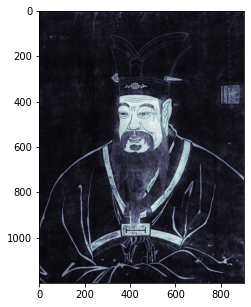

In [15]:
img_325reconstruct = U[:,:325]@S[:325,:325]@V[:325,:]
plt.figure(figsize = (5,5))
plt.imshow(img_325reconstruct,cmap=plt.cm.bone)
plt.imsave('/Users/laurencepalmer/Desktop/img_reconstruct_325.png',img_325reconstruct,cmap = plt.cm.bone)

That's pretty good. Now let's try to take a look at the absolute differences, and calculate the same values we did for the Olivetti Faces.

7957.62287543793 0.060711492641626924


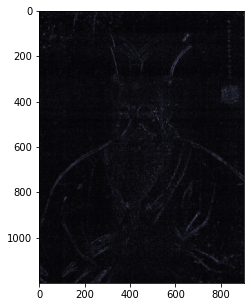

In [16]:
plt.figure(figsize = (5,5))
abs_diff = np.abs(img - img_325reconstruct)
plt.imshow(abs_diff,cmap = plt.cm.bone)
plt.imsave('/Users/laurencepalmer/Desktop/img_reconstruct_abs_diff_325.png',abs_diff,cmap = plt.cm.bone)
print(sum(sum(abs_diff)),sum(sum(abs_diff))/sum(sum(abs(img))))

Let's try this again with a smaller threshold.

157


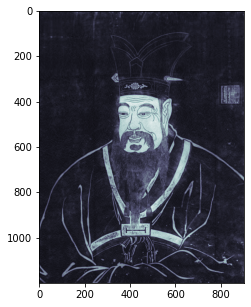

In [18]:
#set threshold and run rank finding procedure again
ranks = 0
summ = 0
sing = np.zeros(903)

#set the percentage threshold
thresh = .75

#there can only be 903 nonzero singular values by the dimensions of the image
totals = sum(S[np.arange(903),np.arange(903)])
for j in range(903):
    summ = S[j,j] + summ
    sing[j] = S[j,j]
    if summ/totals < thresh: #once it reaches the threshold it will stop updating the ranks so this should be the appropriate rank approx
        ranks = j

print(ranks)
img_157reconstruct = U[:,:ranks]@S[:ranks,:ranks]@V[:ranks,:]
plt.figure(figsize = (5,5))
plt.imshow(img_157reconstruct,cmap=plt.cm.bone)
plt.imsave('/Users/laurencepalmer/Desktop/img_reconstruct_157.png',img_157reconstruct,cmap = plt.cm.bone)

18029.946172606513

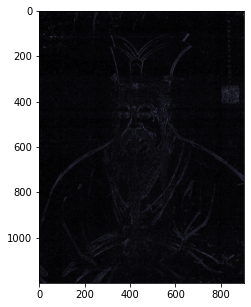

In [19]:
plt.figure(figsize = (5,5))
abs_diff = np.abs(img - img_157reconstruct)
plt.imshow(abs_diff,cmap = plt.cm.bone)
plt.imsave('/Users/laurencepalmer/Desktop/img_reconstruct_abs_diff157.png',abs_diff,cmap = plt.cm.bone)
sum(sum(abs_diff))

Now that's not a very good approximation, as it just looks pretty bad.  We will stick with the rank 325 approximation. Let's see if the storage load changes 

In [20]:
plt.imsave('/Users/laurencepalmer/Desktop/img_reconstruct.png',img_325reconstruct,cmap = plt.cm.bone)

That certainly did not work.  This is because we are not storing the image in factorized form.  As of now, I do not know how to do this.

## Corner Case 

Originally, the algorithm had a bunch of trouble computing the SVD for this simple $3\times 2$ matrix given by 
$$\begin{bmatrix} 1&1 \\ 0 &0 \\ 1&-1 \end{bmatrix}$$.

This is before the sanity_check portion of the algorithm was implemented, let's see whether this issue is still happening after that implementation

In [21]:
A = np.array([[1,1],[0,0],[1,-1]])
U,S,V = SVD(A)
U,S,V

(array([[-0., -1.,  0.],
        [-0., -0.,  1.],
        [-1., -0.,  0.]]),
 array([[1.41421356, 0.        ],
        [0.        , 1.41421356],
        [0.        , 0.        ]]),
 array([[0., 1.],
        [1., 0.]]))

So the issue is still present clearly.  This is because of the fact that the eigenvectors chosen by np.linalg.eig in the U matrix, are $(1,0,0)^T, (0,0,1)^T$ as opposed to $(1,0,1)^T, (1,0,-1)^T$.  If we just change U to be these vectors, orthonormalized then we should get the right answer.  

In [22]:
U = np.transpose(np.array([[1,0,1]/np.sqrt(2),[1,0,-1]/np.sqrt(2),[0,1,0]]))
U@S@V

array([[ 1.,  1.],
       [ 0.,  0.],
       [-1.,  1.]])

Which is the correct reconstruction.  Interestingly, we manage to get enough 

## More Figures ##

These are just figures that explore some other rank approximations

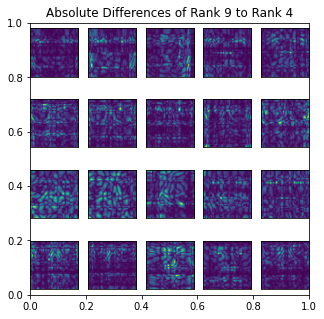

In [23]:
fig = plt.figure(figsize=(5,5))
plt.title('Absolute Differences of Rank 9 to Rank 4')
k = [9,4]

for i in range(20):
    U,S,V = SVD(face.images[2*i])
    ax = fig.add_subplot(4, 5, i+1,xticks = [],yticks = [])
    rank4 = U[:,:k[0]]@S[:k[0],:k[0]]@V[:k[0],:]
    rank9 = U[:,:k[1]]@S[:k[1],:k[1]]@V[:k[1],:]
    diff = rank9 -rank4
    ax.imshow(np.abs(diff))   
    
plt.savefig('/Users/laurencepalmer/Desktop/rank94_differences.png')

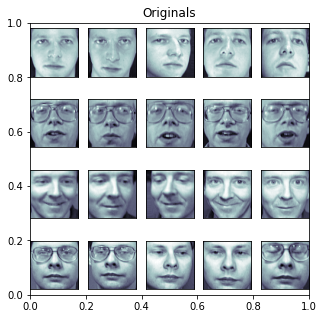

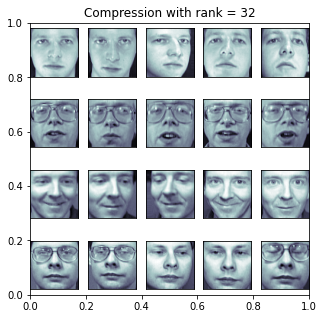

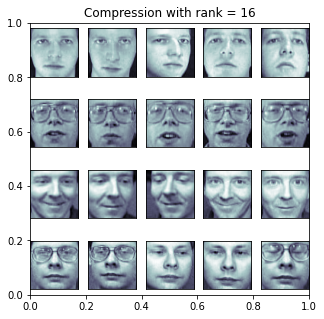

In [24]:
fig = plt.figure(figsize=(5,5))
plt.title('Originals')
k = 64
for i in range(20):
    U,S,V = SVD(face.images[2*i])
    ax = fig.add_subplot(4, 5, i+1,xticks = [],yticks = [])
    ax.imshow(U[:,:k]@S[:k,:k]@V[:k,:], cmap=plt.cm.bone)    #compression step
    
plt.savefig('/Users/laurencepalmer/Desktop/20_oliv_faces_rank64.png')

fig1 = plt.figure(figsize = (5,5))
plt.title('Compression with rank = 32')
k = 32
for i in range(20):
    U,S,V = SVD(face.images[2*i])
    ax = fig1.add_subplot(4, 5, i+1,xticks = [],yticks = [])
    ax.imshow(U[:,:k]@S[:k,:k]@V[:k,:], cmap=plt.cm.bone)    #compression step 
    
plt.savefig('/Users/laurencepalmer/Desktop/20_oliv_faces_rank32.png')

    
fig2 = plt.figure(figsize = (5,5))
plt.title('Compression with rank = 16')
k = 16
for i in range(20):
    U,S,V = SVD(face.images[2*i])
    ax = fig2.add_subplot(4, 5, i+1,xticks = [],yticks = [])
    ax.imshow(U[:,:k]@S[:k,:k]@V[:k,:], cmap=plt.cm.bone)    #compression step
    
plt.savefig('/Users/laurencepalmer/Desktop/20_oliv_faces_rank16.png')

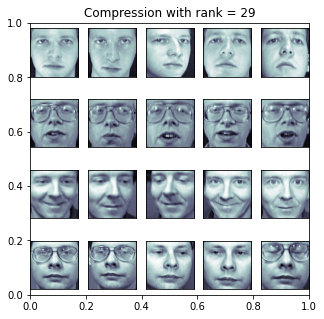

In [25]:
fig1 = plt.figure(figsize = (5,5))
plt.title('Compression with rank = 29')
k = 29
for i in range(20):
    U,S,V = SVD(face.images[2*i])
    ax = fig1.add_subplot(4, 5, i+1,xticks = [],yticks = [])
    ax.imshow(U[:,:k]@S[:k,:k]@V[:k,:], cmap=plt.cm.bone)    #compression step 
    
plt.savefig('/Users/laurencepalmer/Desktop/20_oliv_faces_rank29.png')

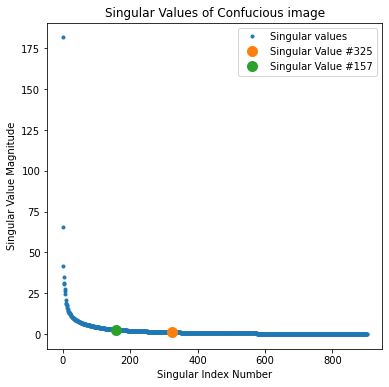

In [28]:
plt.figure(figsize = (6,6))
plt.plot(np.arange(S.shape[1]),sing,'.',label = 'Singular values')
plt.plot(325,sing[325],'.',markersize = 20,label = 'Singular Value #325')
plt.plot(157,sing[157],'.',markersize = 20,label = 'Singular Value #157')
plt.xlabel('Singular Index Number')
plt.ylabel('Singular Value Magnitude')
plt.legend()
plt.title('Singular Values of Confucious image')
plt.savefig('/Users/laurencepalmer/Desktop/sing_values.png')